In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import requests
from shapely.geometry import Point
shp_file = gpd.read_file('datasets/geo_export_26bce2f2-c163-42a9-9329-9ca6e082c5e9.shp')
shp_file.set_crs(epsg=4326, inplace=True)
shp_file['geometry_polygon'] = shp_file['geometry']
shp_file = shp_file.loc[~(shp_file['community']== "OHARE")]
school_progress_21_22 = pd.read_csv("https://data.cityofchicago.org/resource/ngix-dc87.csv")
school_progress_22_23 = pd.read_csv("https://data.cityofchicago.org/resource/d7as-muwj.csv")
school_progress_23_24 = pd.read_csv("https://data.cityofchicago.org/resource/2dn2-x66j.csv")
crime = pd.read_csv("datasets/Crimes_-_2022.csv")
crime['Date'] = pd.to_datetime(crime['Date'])
crime['updated_on'] = pd.to_datetime(crime['Updated On'])
data = pd.read_csv("datasets/My_CHI._My_Future._Programs.csv")
data['Start Date'] = pd.to_datetime(data['Start Date'])
data['End Date'] = pd.to_datetime(data['End Date'])


/var/folders/52/y8mfvm1n6vj12ntkl_p9hqw80000gn/T/ipykernel_72729/99937071.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime['Date'] = pd.to_datetime(crime['Date'])
/var/folders/52/y8mfvm1n6vj12ntkl_p9hqw80000gn/T/ipykernel_72729/99937071.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime['updated_on'] = pd.to_datetime(crime['Updated On'])


## Basic Eda
### 1. Are there any correlations between crime and availability of programs in certain districts when crime incidents happen, and more importantly, does a crime incident mean that programs are affected some considerable time after the incident? 
### 2. Is there such a thing as outlier districts that despite having high crime, they present high student attainment, high graduation rate and a great number of programs? How big of a role does crime play in access to programs and high educational attainment?


## Data preparation and cleaning

### Missing value handling

In [4]:
import geopandas as gpd
from shapely.geometry import Point
# Handle missing values
has_latlong = ~data[['Latitude', 'Longitude']].isna().all(axis=1)
has_location = ~data['Location'].isna()
location_data = data[has_latlong  | has_location]
location_data = location_data[location_data['State'] != 'KS']
# impute geographic cluster name
school_progress_21_22['date'] = pd.to_datetime('2022-09-18')
school_progress_22_23['date'] = pd.to_datetime('2023-06-06')
school_progress_23_24['date'] = pd.to_datetime('2024-10-21')
school_progress = pd.concat([school_progress_21_22, school_progress_22_23, school_progress_23_24], axis=0) # no missing zip codes, no missing latitudes and longitudes
crime.dropna(axis='rows',how='any', inplace=True) 

In [5]:
location_data = location_data.copy()
location_data.drop(['Image', 'Program URL', 'Registration URL', 'Registration Open', 
                   'Contact Phone', 'Contact Email', 'Hidden Programs', 'Featured', 
                   'Meeting Type', 'Has Free Food', 'Transport Provided', 'Participants Paid', 'Contact Name', 'Program ID', 
                   'Online Address', 'State', 'Registration Deadline', 'Scholarship Available'], 
                   axis='columns', inplace=True)

### Impute geographic cluster name

In [6]:
geometry = [Point(xy) for xy in zip(location_data['Longitude'], location_data['Latitude'])]
gdf_points = gpd.GeoDataFrame(location_data, geometry=geometry)
gdf_points.set_crs(epsg=4326, inplace=True)
points_with_labels = gpd.sjoin(gdf_points, shp_file, how='left', predicate='within')


In [7]:
points_with_labels = points_with_labels.dropna(subset=['community'])

In [8]:
points_with_labels = points_with_labels.loc[~(points_with_labels['community'] == 'OHARE')]

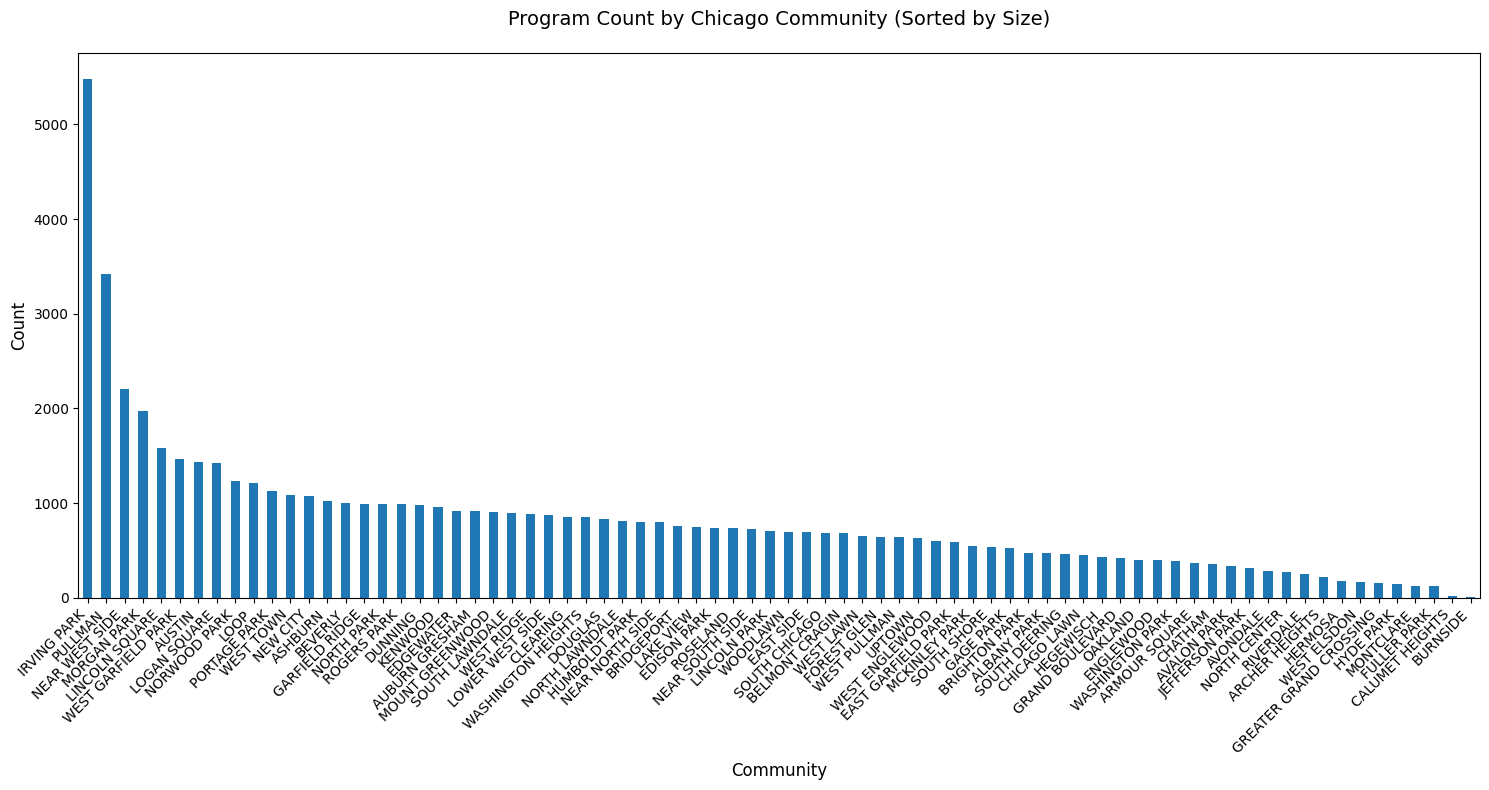

In [9]:
grouped_sizes = points_with_labels[points_with_labels['Start Date'].dt.year == 2022].groupby('community').size()
grouped_sizes_sorted = grouped_sizes.sort_values(ascending=False)

plt.figure(figsize=(15, 8))

bars = grouped_sizes_sorted.plot(kind='bar')

plt.title('Program Count by Chicago Community (Sorted by Size)', fontsize=14, pad=20)
plt.xlabel('Community', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(rotation=45, ha='right')



plt.tight_layout()
plt.show()


/var/folders/52/y8mfvm1n6vj12ntkl_p9hqw80000gn/T/ipykernel_72729/1579885614.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  crime_sum['centroid'] = crime_sum['geometry_polygon'].centroid


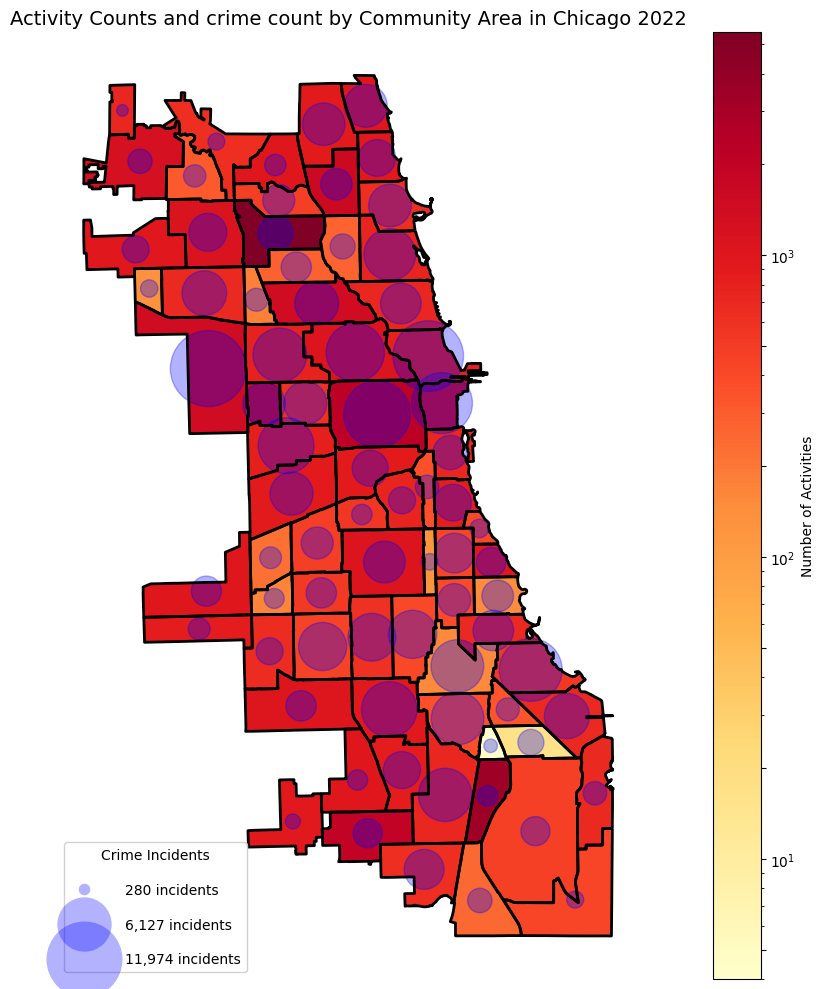

In [10]:
from matplotlib.lines import Line2D
from shapely import wkt
from matplotlib.colors import LogNorm

community_counts = points_with_labels[points_with_labels['Start Date'].dt.year == 2022].groupby('community').size().reset_index(name='count')
    

community_gdf = community_counts.merge(points_with_labels, how='left', on='community').drop_duplicates(subset='community')[['community', 'count', 'geometry_polygon']]
community_gdf = gpd.GeoDataFrame(community_gdf, geometry='geometry_polygon')

fig, ax = plt.subplots(figsize=(15, 10))

community_gdf.plot(
    column='count',
    ax=ax,
    legend=True,
    legend_kwds={
        'label': 'Number of Activities',
        'orientation': 'vertical',
        'ticks': [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 10000]  # Custom tick locations
    },
    missing_kwds={'color': 'lightgrey'},
    cmap='YlOrRd',
    norm=LogNorm()
)


geometry = [Point(xy) for xy in zip(crime['Longitude'], crime['Latitude'])]
crime_gdf_points = gpd.GeoDataFrame(crime, geometry=geometry)
crime_gdf_points.set_crs(epsg=4326, inplace=True)
crime_points_with_labels = gpd.sjoin(crime_gdf_points, shp_file, how='left', predicate='within')
crime_sum = crime_points_with_labels.groupby('community').size().reset_index(name='count')
crime_sum = crime_sum.merge(crime_points_with_labels, how='left', on='community').drop_duplicates(subset='community')[['community', 'count', 'geometry_polygon']]
crime_sum = gpd.GeoDataFrame(crime_sum, geometry='geometry_polygon', crs="EPSG:4326")
crime_sum['centroid'] = crime_sum['geometry_polygon'].centroid
crime_sum.set_geometry('centroid',inplace=True)
min_count = crime_sum['count'].min()
max_count = crime_sum['count'].max()
crime_sum.plot(
    ax=ax,
    color='blue',  
    alpha=0.3,     
    marker='.',   
    markersize=crime_sum['count'],   
)
shp_file.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

legend_elements = [Line2D([0], [0], marker='.', color='w', 
                         markerfacecolor='blue', markersize=10, alpha=0.3,
                         label='Crime Incidents (Larger is worse)')]
ax.legend(handles=legend_elements, loc='upper left')
legend_sizes = [
    min_count,
    (min_count + max_count) / 2, 
    max_count
]
legend_elements = []
for size in legend_sizes:
    legend_elements.append(
        Line2D([0], [0],
               marker='o',
               color='none',
               markerfacecolor='blue',
               markeredgecolor='none',
               markersize=np.sqrt(size)*0.5,  
               alpha=0.3,
               label=f'{int(size):,} incidents')
    )

plt.legend(handles=legend_elements,
          title='Crime Incidents',
          loc='upper left',
          frameon=True,
          framealpha=0.9)

plt.legend(handles=legend_elements,
          title='Crime Incidents',
          loc='lower left',
          frameon=True,
          framealpha=0.9, 
          labelspacing=1.5,   
          handletextpad=2,
 bbox_to_anchor=(0.00, 0.00))
plt.title('Activity Counts and crime count by Community Area in Chicago 2022', fontsize=14)
ax.set_axis_off()
plt.tight_layout()


In [11]:
crime_sum.loc[crime_sum['count'].idxmax()]

community                                                      AUSTIN
count                                                           11974
geometry_polygon    POLYGON ((-87.78941511405804 41.91751009632965...
centroid                POINT (-87.76311182422583 41.894101296113426)
Name: 12583, dtype: object

In [12]:
crime_sum.loc[crime_sum['count'].idxmin()]

community                                                 EDISON PARK
count                                                             280
geometry_polygon    POLYGON ((-87.80675853375328 42.00083736081486...
centroid                 POINT (-87.81378102747257 42.00761315249504)
Name: 61719, dtype: object

In [13]:
community_gdf.loc[community_gdf['count'].idxmax()]

community                                                 IRVING PARK
count                                                            5482
geometry_polygon    POLYGON ((-87.69474577254876 41.96127342577635...
Name: 69591, dtype: object

In [14]:
# correlation between crime and number of programs
points_with_labels_2022 = points_with_labels[points_with_labels['Start Date'].dt.year == 2022].copy()
points_with_labels_2022['month'] = points_with_labels_2022['Start Date'].dt.month
programs_by_month = points_with_labels_2022.groupby(['community', 'month']).size()
programs_by_month = programs_by_month.reset_index(name='program_count')

In [15]:
# for the same district, for the same month, is there a correlation between number of crimes and number of programs...
crime_points_with_labels['month'] = crime_points_with_labels.Date.dt.month
crimes_by_month = crime_points_with_labels.groupby(['community','month']).size()
crimes_by_month = crimes_by_month.reset_index(name='crime_count', )

In [16]:
merged_df = programs_by_month.merge(crimes_by_month, on=['community', 'month'])

In [17]:
# Difference of 4 orders of magnitude between the communities such as Burnside or Calumet Heights
merged_df['program_count'].corr(merged_df['crime_count'])

np.float64(0.04671804847757368)

/Users/pedro/Documents/Coding Projects 2024/STAT_303-1_Final_Project/venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/pedro/Documents/Coding Projects 2024/STAT_303-1_Final_Project/venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/pedro/Documents/Coding Projects 2024/STAT_303-1_Final_Project/venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/var/folders/52/y8mfvm1n6vj12ntkl_p9hqw80000gn/T/ipykernel_72729/2323275540.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to 

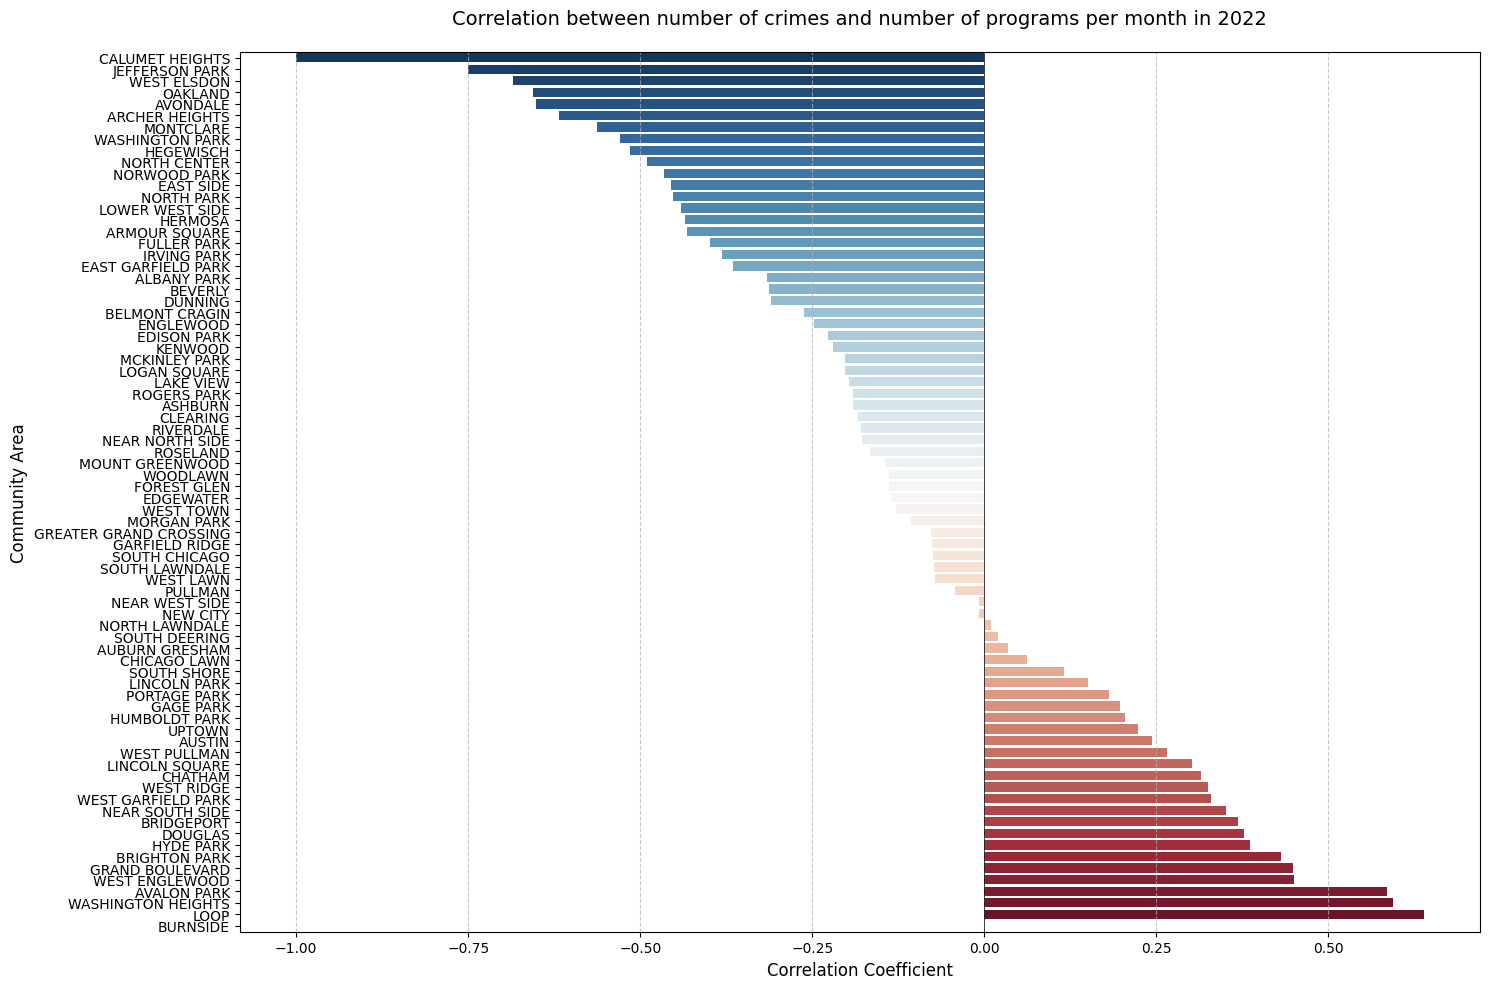

In [18]:
community_correlations = merged_df.groupby('community').apply(
    lambda x: x['program_count'].corr(x['crime_count'])
)
sorted_corr = community_correlations.sort_values()
    
# Create figure with appropriate size
plt.figure(figsize=(15, 10))

# Create horizontal bar plot
ax = sns.barplot(x=sorted_corr.values, 
                y=sorted_corr.index,
                palette="RdBu_r",  # Red-Blue diverging palette
                )

# Customize the plot
plt.title("Correlation between number of crimes and number of programs per month in 2022", pad=20, size=14)
plt.xlabel("Correlation Coefficient", size=12)
plt.ylabel("Community Area", size=12)

# Add a vertical line at x=0
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Add grid lines
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()


In [19]:

from scipy.stats import binned_statistic
def analyze_program_slowdown(df, community, month, bin_size=5):
    """
    Analyze and visualize the relationship between crime count and program count,
    highlighting the slowdown effect.
    
    Parameters:
    df: DataFrame containing crime_count and program_count columns
    community: str, community to analyze
    month: int or str, month to analyze
    bin_size: int, size of bins for averaging
    """
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])
    
    # Filter data for specific community and month
    data = df[df['community'] == community]
    if month is not None:
        data = data[data['month'] == month]
    
    # Sort by crime count
    data = data.sort_values('crime_count')
    
    # Calculate rolling average of program count
    x = data['crime_count']
    y = data['program_count']
    
    # Create bins and calculate statistics
    bins = np.arange(x.min(), x.max() + bin_size, bin_size)
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate percentage change between consecutive bins
    pct_changes = np.diff(bin_means) / bin_means[:-1] * 100
    
    # Plot 1: Program Count vs Crime Count
    ax1.scatter(x, y, alpha=0.5, label='Individual Data Points')
    ax1.plot(bin_centers, bin_means, 'r-', linewidth=2, label='Average Trend')
    
    # Find potential slowdown point (where percentage change becomes consistently negative)
    slowdown_idx = np.where(pct_changes < -10)[0]
    if len(slowdown_idx) > 0:
        slowdown_point = bin_centers[slowdown_idx[0]]
        ax1.axvline(x=slowdown_point, color='g', linestyle='--', 
                   label=f'Slowdown Point ({slowdown_point:.0f} crimes)')
    
    ax1.set_title(f'Program Count vs Crime Count in {community}' + 
                 (f' - Month {month}' if month is not None else ''))
    ax1.set_xlabel('Number of Crimes')
    ax1.set_ylabel('Program Count')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Percentage Change
    ax2.bar(bin_centers[:-1], pct_changes, width=bin_size*0.8)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel('Number of Crimes')
    ax2.set_ylabel('% Change in Program Count')
    ax2.grid(True, alpha=0.3)
    
    # Calculate average slowdown after the identified point
    if len(slowdown_idx) > 0:
        avg_slowdown = np.mean(pct_changes[slowdown_idx[0]:])
        ax2.text(0.02, 0.98, f'Average Slowdown: {avg_slowdown:.1f}%',
                transform=ax2.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return plt


In [20]:
points_with_labels_2022 = points_with_labels[points_with_labels['Start Date'].dt.year == 2022].copy()
points_with_labels_2022['date'] = points_with_labels_2022['Start Date'].dt.date  # Removes time component
programs_by_day = points_with_labels_2022.groupby(['community', 'date']).size()
programs_by_day = programs_by_day.reset_index(name='program_count')

# Add day column to crimes dataframe
crime_points_with_labels['date'] = crime_points_with_labels.Date.dt.date  # Removes time component
crimes_by_day = crime_points_with_labels.groupby(['community', 'date']).size()
crimes_by_day = crimes_by_day.reset_index(name='crime_count')

# Merge the dataframes on community and date
merged_daily_df = programs_by_day.merge(crimes_by_day, on=['community', 'date'])

# If you want to add month and day columns separately for additional analysis:
merged_daily_df['month'] = pd.to_datetime(merged_daily_df['date']).dt.month
merged_daily_df['day'] = pd.to_datetime(merged_daily_df['date']).dt.day

# Sort by date for time series analysis
merged_daily_df = merged_daily_df.sort_values(['community', 'date'])

In [21]:
merged_daily_df

,community,date,program_count,crime_count,month,day
0,ALBANY PARK,2022-01-03,18,5,1,3
1,ALBANY PARK,2022-01-04,18,4,1,4
2,ALBANY PARK,2022-01-05,10,6,1,5
3,ALBANY PARK,2022-01-06,6,1,1,6
4,ALBANY PARK,2022-01-07,14,1,1,7
...,...,...,...,...,...,...
9078,WOODLAWN,2022-12-14,3,13,12,14
9079,WOODLAWN,2022-12-20,3,8,12,20
9080,WOODLAWN,2022-12-21,6,12,12,21
9081,WOODLAWN,2022-12-27,6,10,12,27


<module 'matplotlib.pyplot' from '/Users/pedro/Documents/Coding Projects 2024/STAT_303-1_Final_Project/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

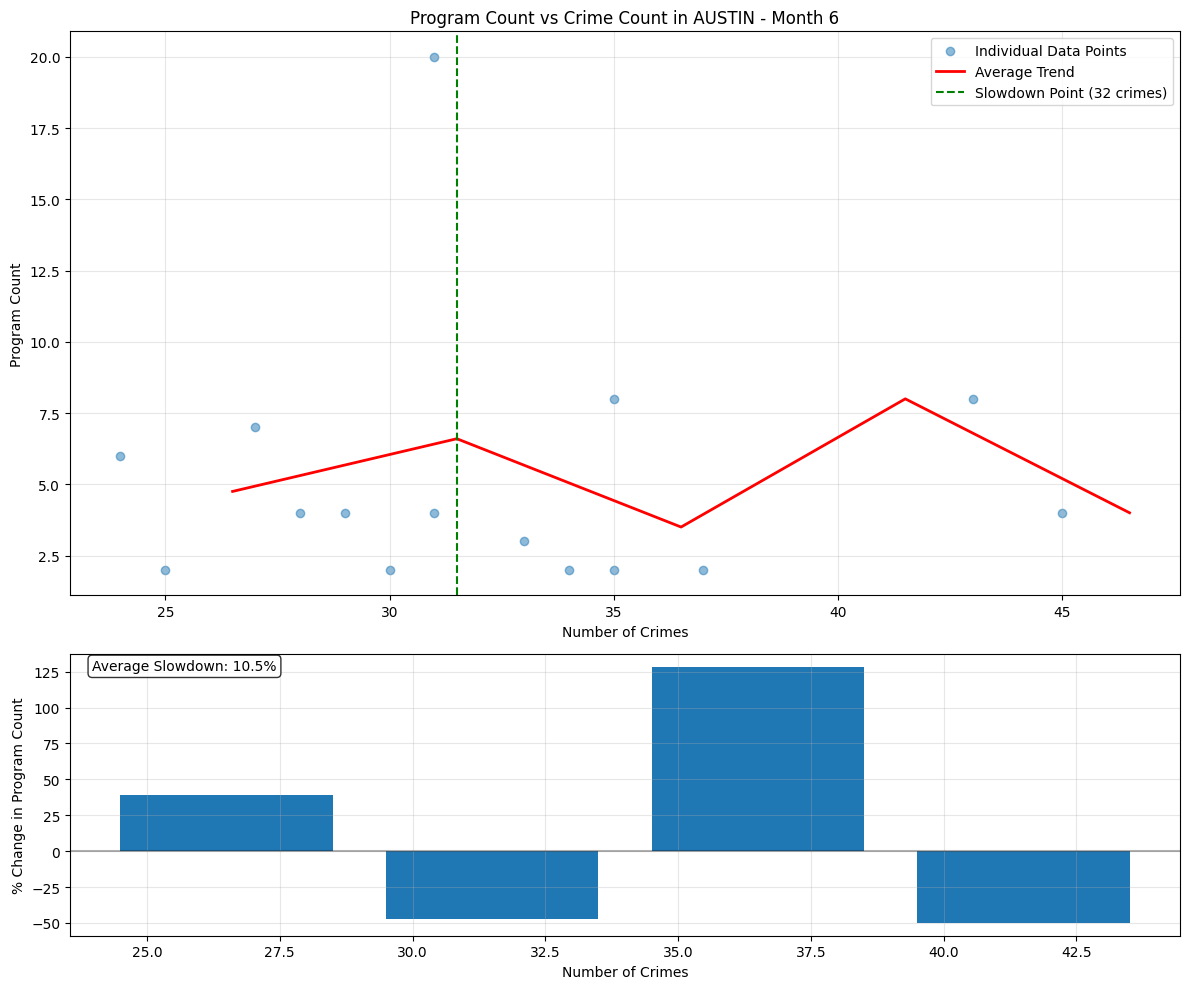

In [22]:
analyze_program_slowdown(merged_daily_df, "AUSTIN", 6)

In [23]:

from scipy.stats import binned_statistic
def analyze_program_slowdown_year(df, community, year, bin_size=5):
    """
    Analyze and visualize the relationship between crime count and program count,
    highlighting the slowdown effect.
    
    Parameters:
    df: DataFrame containing crime_count and program_count columns
    community: str, community to analyze
    month: int or str, month to analyze
    bin_size: int, size of bins for averaging
    """
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])
    
    # Filter data for specific community and month
    data = df[df['community'] == community]
    if year is not None:
        data = data[data['year'] == year]
    
    # Sort by crime count
    data = data.sort_values('crime_count')
    
    # Calculate rolling average of program count
    x = data['crime_count']
    y = data['program_count']
    
    # Create bins and calculate statistics
    bins = np.arange(x.min(), x.max() + bin_size, bin_size)
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate percentage change between consecutive bins
    pct_changes = np.diff(bin_means) / bin_means[:-1] * 100
    
    # Plot 1: Program Count vs Crime Count
    ax1.scatter(x, y, alpha=0.5, label='Individual Data Points')
    ax1.plot(bin_centers, bin_means, 'r-', linewidth=2, label='Average Trend')
    
    # Find potential slowdown point (where percentage change becomes consistently negative)
    slowdown_idx = np.where(pct_changes < -10)[0]
    if len(slowdown_idx) > 0:
        slowdown_point = bin_centers[slowdown_idx[0]]
        ax1.axvline(x=slowdown_point, color='g', linestyle='--', 
                   label=f'Slowdown Point ({slowdown_point:.0f} crimes)')
    
    ax1.set_title(f'Program Count vs Crime Count in {community}' + 
                 (f' - Year {2022}' if year is not None else ''))
    ax1.set_xlabel('Number of Crimes')
    ax1.set_ylabel('Program Count')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Percentage Change
    ax2.bar(bin_centers[:-1], pct_changes, width=bin_size*0.8)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel('Number of Crimes')
    ax2.set_ylabel('% Change in Program Count')
    ax2.grid(True, alpha=0.3)
    
    # Calculate average slowdown after the identified point
    if len(slowdown_idx) > 0:
        avg_slowdown = np.mean(pct_changes[slowdown_idx[0]:])
        ax2.text(0.02, 0.98, f'Average Slowdown: {avg_slowdown:.1f}%',
                transform=ax2.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return plt


ValueError: arange: cannot compute length

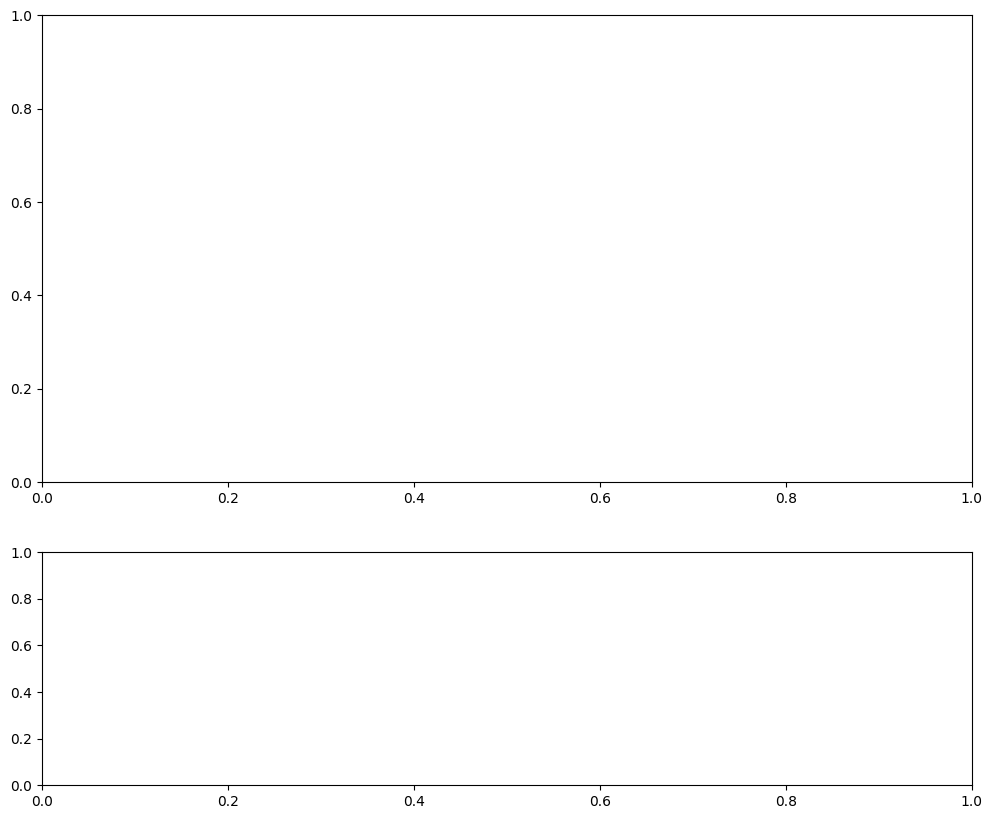

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binned_statistic

# Your merged_df already contains: community, month, program_count, crime_count
# Add year column (since we know it's 2022 data)
merged_df['year'] = 2022

def analyze_program_slowdown_year(df, community, year=2022, bin_size=5):
    """
    Analyze and visualize the relationship between crime count and program count,
    highlighting the slowdown effect.
    
    Parameters:
    df: DataFrame containing crime_count and program_count columns
    community: str, community to analyze
    year: int, year to analyze (defaults to 2022)
    bin_size: int, size of bins for averaging
    """
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])
    
    # Filter data for specific community and year
    data = df[df['community'] == community]
    if year is not None:
        data = data[data['year'] == year]
    
    # Sort by crime count
    data = data.sort_values('crime_count')
    
    # Calculate rolling average of program count
    x = data['crime_count']
    y = data['program_count']
    
    # Create bins and calculate statistics
    bins = np.arange(x.min(), x.max() + bin_size, bin_size)
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate percentage change between consecutive bins
    pct_changes = np.diff(bin_means) / bin_means[:-1] * 100
    
    # Plot 1: Program Count vs Crime Count
    ax1.scatter(x, y, alpha=0.5, label='Individual Data Points')
    ax1.plot(bin_centers, bin_means, 'r-', linewidth=2, label='Average Trend')
    
    # Find potential slowdown point (where percentage change becomes consistently negative)
    slowdown_idx = np.where(pct_changes < -10)[0]
    if len(slowdown_idx) > 0:
        slowdown_point = bin_centers[slowdown_idx[0]]
        ax1.axvline(x=slowdown_point, color='g', linestyle='--',
                   label=f'Slowdown Point ({slowdown_point:.0f} crimes)')
    
    ax1.set_title(f'Program Count vs Crime Count in {community}' +
                 (f' - Year {year}' if year is not None else ''))
    ax1.set_xlabel('Number of Crimes')
    ax1.set_ylabel('Program Count')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Percentage Change
    ax2.bar(bin_centers[:-1], pct_changes, width=bin_size*0.8)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel('Number of Crimes')
    ax2.set_ylabel('% Change in Program Count')
    ax2.grid(True, alpha=0.3)
    
    # Calculate average slowdown after the identified point
    if len(slowdown_idx) > 0:
        avg_slowdown = np.mean(pct_changes[slowdown_idx[0]:])
        ax2.text(0.02, 0.98, f'Average Slowdown: {avg_slowdown:.1f}%',
                transform=ax2.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return plt

# Example usage for a specific community:
analyze_program_slowdown_year(merged_df, '')
plt.show()

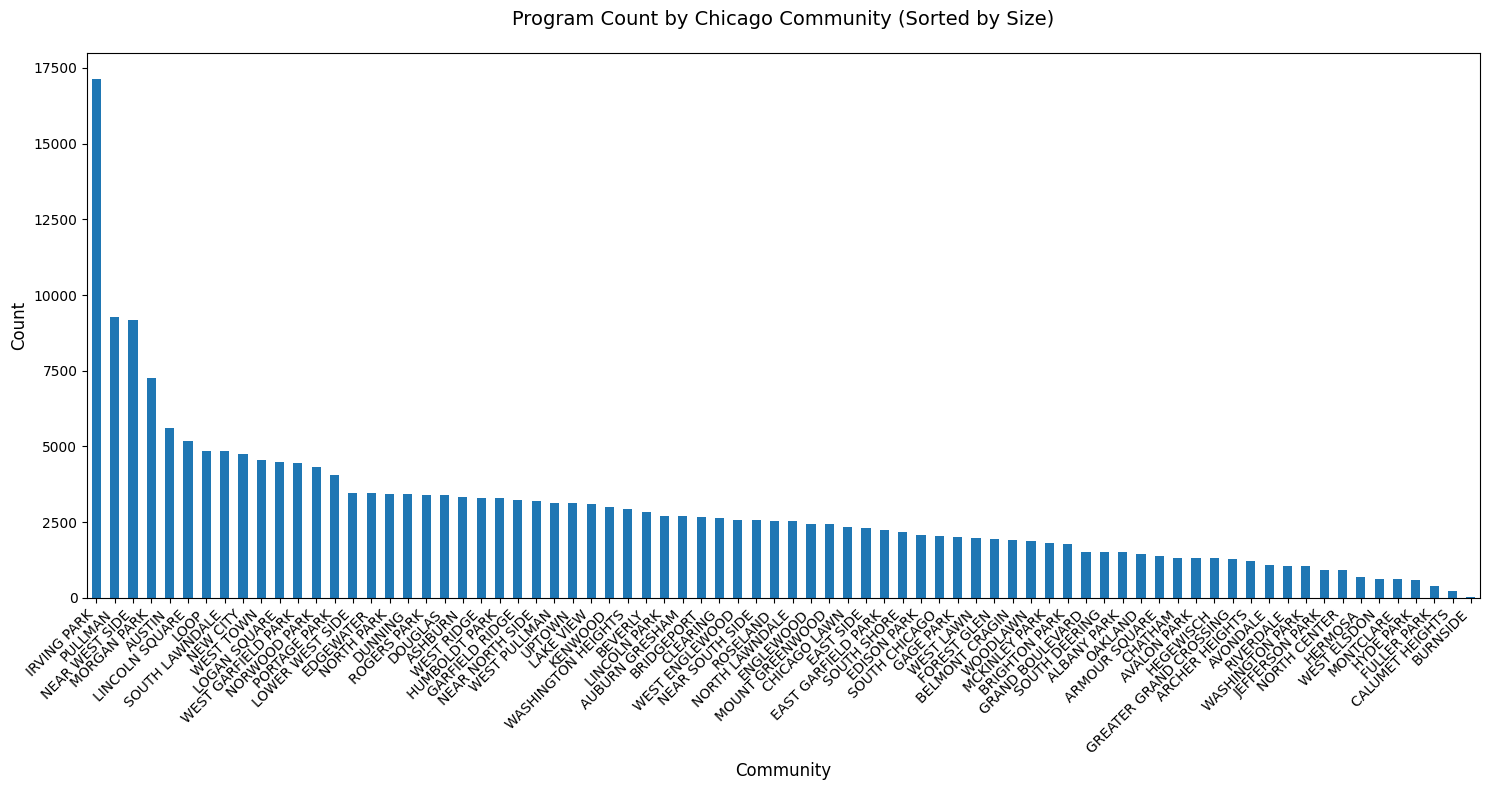

In [26]:
grouped_sizes = points_with_labels.groupby(['community']).size()
grouped_sizes_sorted = grouped_sizes.sort_values(ascending=False)

plt.figure(figsize=(15, 8))

bars = grouped_sizes_sorted.plot(kind='bar')

plt.title('Program Count by Chicago Community (Sorted by Size)', fontsize=14, pad=20)
plt.xlabel('Community', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(rotation=45, ha='right')



plt.tight_layout()
plt.show()

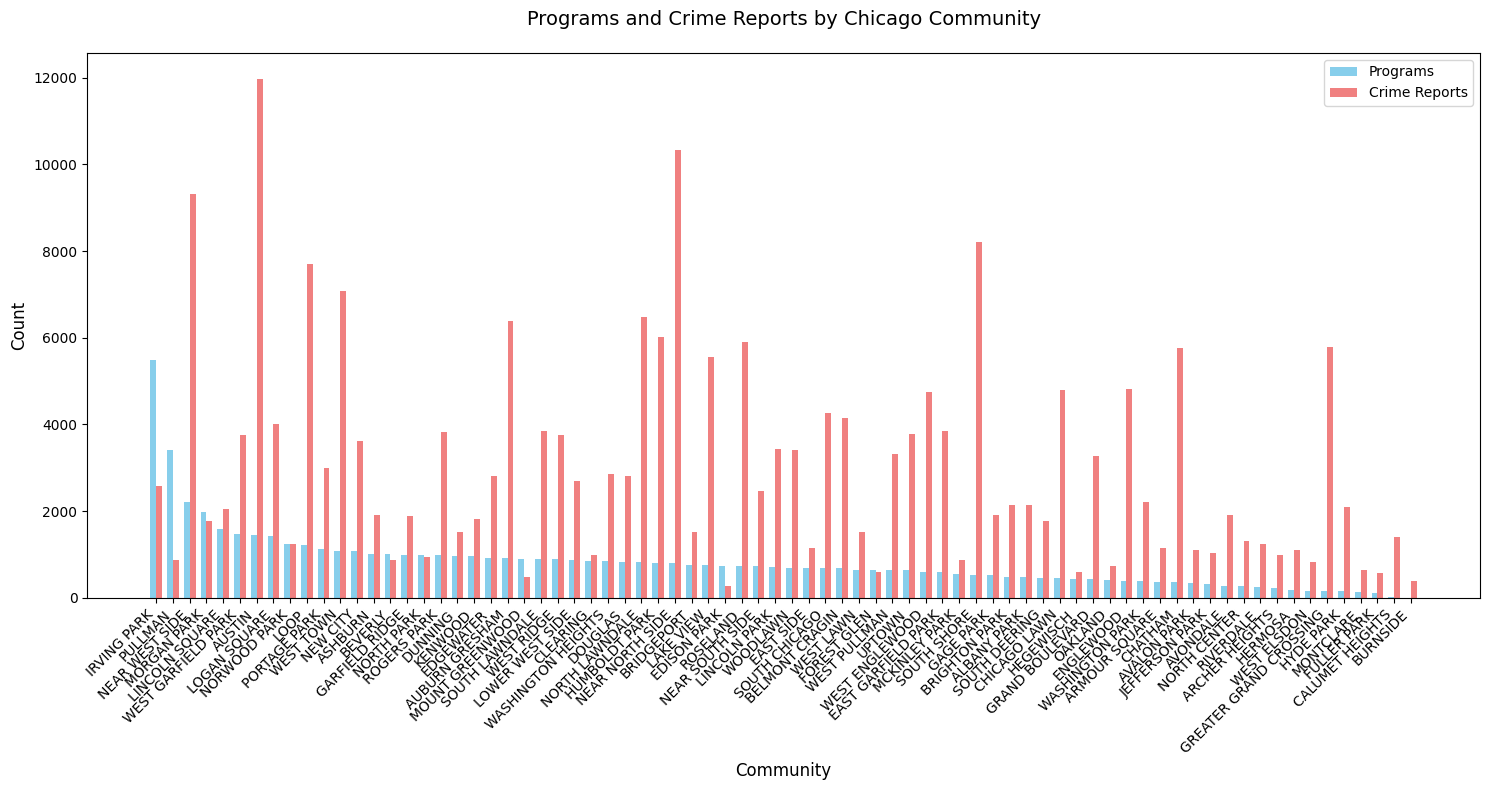

In [ ]:
grouped_sizes = points_with_labels[points_with_labels['Start Date'].dt.year == 2022].groupby('community').size()
grouped_sizes_sorted = grouped_sizes.sort_values(ascending=False)
crime_sorted = crime_points_with_labels.groupby('community').size()


plt.figure(figsize=(15, 8))

x = np.arange(len(grouped_sizes_sorted))

width = 0.35
x_programs = x - width/2
x_crimes = x + width/2

plt.bar(x_programs, grouped_sizes_sorted, width, label='Programs', color='skyblue')
plt.bar(x_crimes, crime_sorted[grouped_sizes_sorted.index], width, label='Crime Reports', color='lightcoral')

plt.title('Programs and Crime Reports by Chicago Community', fontsize=14, pad=20)
plt.xlabel('Community', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(x, grouped_sizes_sorted.index, rotation=45, ha='right')

# Add legend
plt.legend()

plt.tight_layout()

plt.show()


### Crime and number of programs...

### Merge datasets and derive additional variables